In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
from joblib import Parallel, delayed
import warnings

# Methods:
from src import feature_engineering_methods as fem

warnings.filterwarnings("ignore")

In [2]:
try:
    indicators_df = pd.read_parquet("../data/proccesed_data/indicators.parquet")
    election_df = pd.read_parquet("../data/proccesed_data/presidential_election.parquet")

except FileNotFoundError:
    print("Some datasets are missing.")

In [3]:
election_df.head()

,county,terc_code,turnout_percentage,year,round
0,bolesławiecki,0201,58.50,2000,1
1,bolesławiecki,0201,44.16,2005,1
2,bolesławiecki,0201,45.09,2005,2
3,bolesławiecki,0201,50.33,2010,1
4,bolesławiecki,0201,49.09,2010,2


In [4]:
indicators_df.head()
indicators_df[indicators_df["unemployment"].isna()]

,terc_code,county,year,population_density,population_70_plus,total_population,urbanization_rate,demographic_dependency_ratio,average_gross_salary,unemployment,gdp_per_capita


# 1. Indicators preparation

### Due to the fact that the presidential elections in Poland take place in spring and the Central Statistical Office publishes most of the data for a given year in the following year, voters do not have access to data on economic and demographic indicators in the election year. 

### In order to maintain a realistic representation of the impact of these indicators on voter turnout, it was decided to move the indicators forward by one year, so that the model could use the indicators and their reading and interpretation would reflect reality as closely as possible.

### Due to this, data on indicators for 1999 were calculated by linear extrapolation so that after the shift we would have a complete set of data from 2000 to 2025.

In [5]:
target_columns = indicators_df.columns.tolist()
target_columns = target_columns[3:]

indicators_df = fem.extrapolate_1999_data(indicators_df, target_columns)

# Copy of indicators_df to predict data for 2000-2030 in the future
indicators_to_predict_2030_df = indicators_df.copy()

indicators_df[indicators_df.isna().any(axis= 1)]

,terc_code,county,year,population_density,population_70_plus,total_population,urbanization_rate,demographic_dependency_ratio,average_gross_salary,unemployment,gdp_per_capita


In [6]:
indicators_df.head()

,terc_code,county,year,population_density,population_70_plus,total_population,urbanization_rate,demographic_dependency_ratio,average_gross_salary,unemployment,gdp_per_capita
0,0201,bolesławiecki,1999,67.3,5011.0,88312.0,52.0,66.0,1860.00,8554.0,19537.0
1,0201,bolesławiecki,2000,67.4,5319.0,88194.0,52.0,64.0,1850.00,8886.0,20088.0
2,0201,bolesławiecki,2001,67.5,5627.0,88076.0,52.0,62.0,1840.00,9218.0,20639.0
3,0201,bolesławiecki,2002,67.6,6484.0,88132.0,52.0,60.0,1873.59,8574.0,21744.0
4,0201,bolesławiecki,2003,67.8,6771.0,88308.0,51.0,58.2,1951.43,8803.0,22608.0


### In order to ensure the consistency of the model's time ranges, only data on indicators from election years was left, which were combined with election data. 

### However, in order for the model to use information on how individual indicators have changed over the years between elections and compared to the previous year, delta columns corresponding to these values ​​were used.

### Due to the fact that it is not possible to calculate the delta for the year 2000 from current data, the values ​​in these columns will remain NaN for this year.

### Forecasting data back to 1995 on the basis of data after 2000 would give a false result, because after 1995 there were many reforms as a result of which the economy flourished in later years.

### This will not be a problem for predictive models that can cope quite well with such lack of data, but reducing the range to 2005-2025 would result in printing out sparse electoral data by almost 20%.



In [7]:
indicators_df = fem.prepare_lagged_features(indicators_df, target_columns)

del target_columns
indicators_df.head()

,terc_code,county,year,population_density,population_70_plus,total_population,urbanization_rate,demographic_dependency_ratio,average_gross_salary,unemployment,...,urbanization_rate_delta_1_year,urbanization_rate_delta_5_years,demographic_dependency_ratio_delta_1_year,demographic_dependency_ratio_delta_5_years,average_gross_salary_delta_1_year,average_gross_salary_delta_5_years,unemployment_delta_1_year,unemployment_delta_5_years,gdp_per_capita_delta_1_year,gdp_per_capita_delta_5_years
0,0201,bolesławiecki,2000,67.3,5011.0,88312.0,52.0,66.0,1860.00,8554.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0201,bolesławiecki,2001,67.4,5319.0,88194.0,52.0,64.0,1850.00,8886.0,...,0.0,NaN,-2.0,NaN,-10.00,NaN,332.0,NaN,551.0,NaN
2,0201,bolesławiecki,2002,67.5,5627.0,88076.0,52.0,62.0,1840.00,9218.0,...,0.0,NaN,-2.0,NaN,-10.00,NaN,332.0,NaN,551.0,NaN
3,0201,bolesławiecki,2003,67.6,6484.0,88132.0,52.0,60.0,1873.59,8574.0,...,0.0,NaN,-2.0,NaN,33.59,NaN,-644.0,NaN,1105.0,NaN
4,0201,bolesławiecki,2004,67.8,6771.0,88308.0,51.0,58.2,1951.43,8803.0,...,-1.0,NaN,-1.8,NaN,77.84,NaN,229.0,NaN,864.0,NaN


In [8]:
election_years = [2000, 2005, 2010, 2015, 2020, 2025]
model_set_df = fem.merge_election_data(election_df, indicators_df, election_years)

del election_years
model_set_df[model_set_df.isna().any(axis= 1)]

,county,terc_code,turnout_percentage,year,round,population_density,population_70_plus,total_population,urbanization_rate,demographic_dependency_ratio,...,urbanization_rate_delta_1_year,urbanization_rate_delta_5_years,demographic_dependency_ratio_delta_1_year,demographic_dependency_ratio_delta_5_years,average_gross_salary_delta_1_year,average_gross_salary_delta_5_years,unemployment_delta_1_year,unemployment_delta_5_years,gdp_per_capita_delta_1_year,gdp_per_capita_delta_5_years
0,bolesławiecki,0201,58.50,2000,1,67.3,5011.0,88312.0,52.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,dzierżoniowski,0202,59.52,2000,1,225.0,9164.0,109119.0,82.0,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,głogowski,0203,64.83,2000,1,199.1,3935.0,87841.0,82.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,górowski,0204,57.98,2000,1,50.2,2725.0,37329.0,42.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,jaworski,0205,58.28,2000,1,91.3,4087.0,53902.0,58.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4125,wałecki,3217,60.47,2000,1,39.5,3186.0,56178.0,61.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4136,łobeski,3218,56.97,2000,1,36.5,3027.0,39366.0,52.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4147,Koszalin,3261,67.94,2000,1,1315.5,6281.0,108899.0,0.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4158,Szczecin,3262,63.38,2000,1,1396.6,31295.0,420401.0,0.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
model_set_df.head()

,county,terc_code,turnout_percentage,year,round,population_density,population_70_plus,total_population,urbanization_rate,demographic_dependency_ratio,...,urbanization_rate_delta_1_year,urbanization_rate_delta_5_years,demographic_dependency_ratio_delta_1_year,demographic_dependency_ratio_delta_5_years,average_gross_salary_delta_1_year,average_gross_salary_delta_5_years,unemployment_delta_1_year,unemployment_delta_5_years,gdp_per_capita_delta_1_year,gdp_per_capita_delta_5_years
0,bolesławiecki,0201,58.50,2000,1,67.3,5011.0,88312.0,52.00,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bolesławiecki,0201,44.16,2005,1,67.8,7023.0,88378.0,51.00,56.5,...,0.00,-1.00,-1.7,-9.5,75.86,167.29,-837.0,-588.0,2013.0,5084.0
2,bolesławiecki,0201,45.09,2005,2,67.8,7023.0,88378.0,51.00,56.5,...,0.00,-1.00,-1.7,-9.5,75.86,167.29,-837.0,-588.0,2013.0,5084.0
3,bolesławiecki,0201,50.33,2010,1,68.3,7935.0,89051.0,49.47,52.9,...,-0.38,-1.53,0.0,-3.6,152.60,601.72,1354.0,-3184.0,2319.0,14142.0
4,bolesławiecki,0201,49.09,2010,2,68.3,7935.0,89051.0,49.47,52.9,...,-0.38,-1.53,0.0,-3.6,152.60,601.72,1354.0,-3184.0,2319.0,14142.0


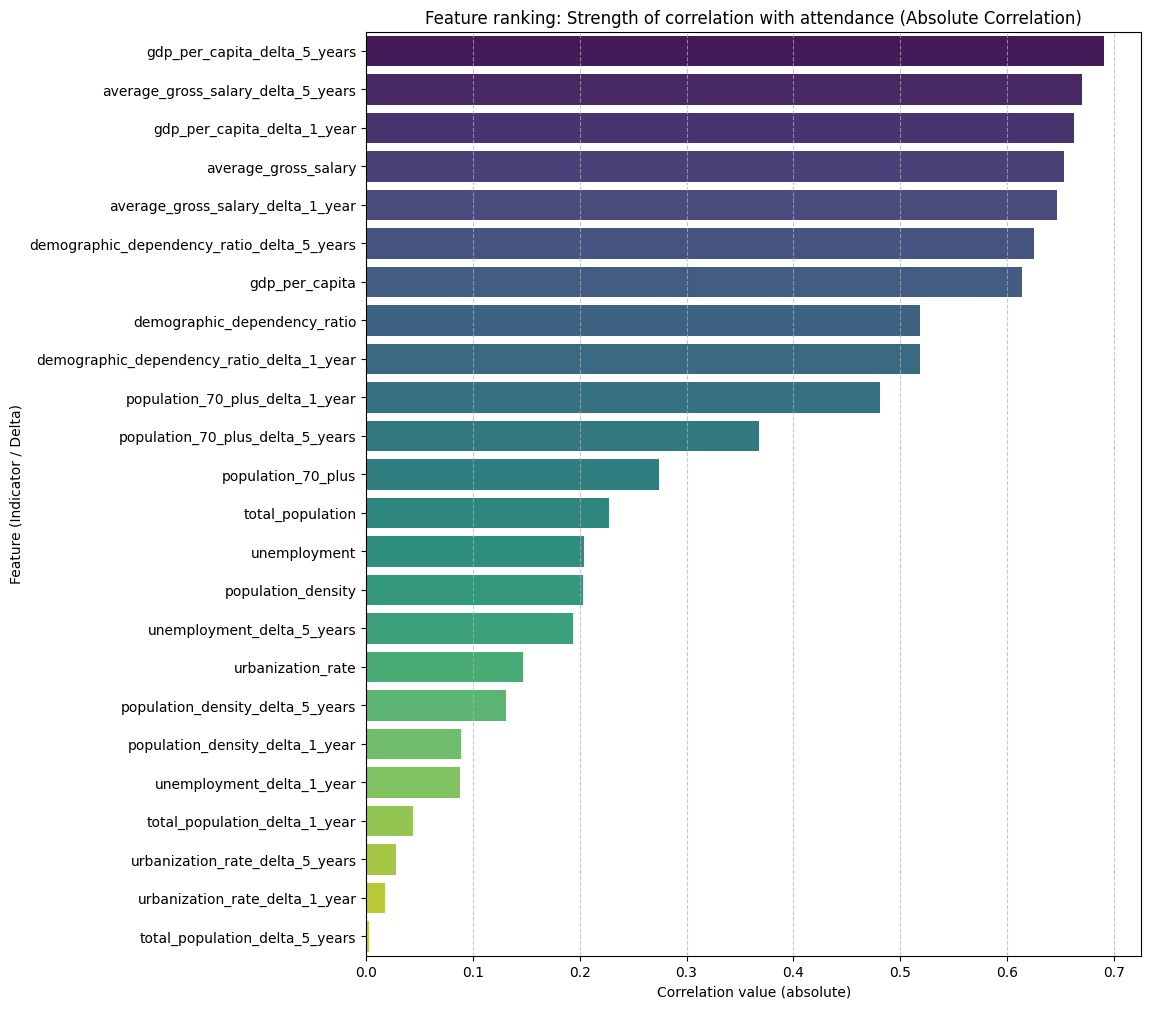

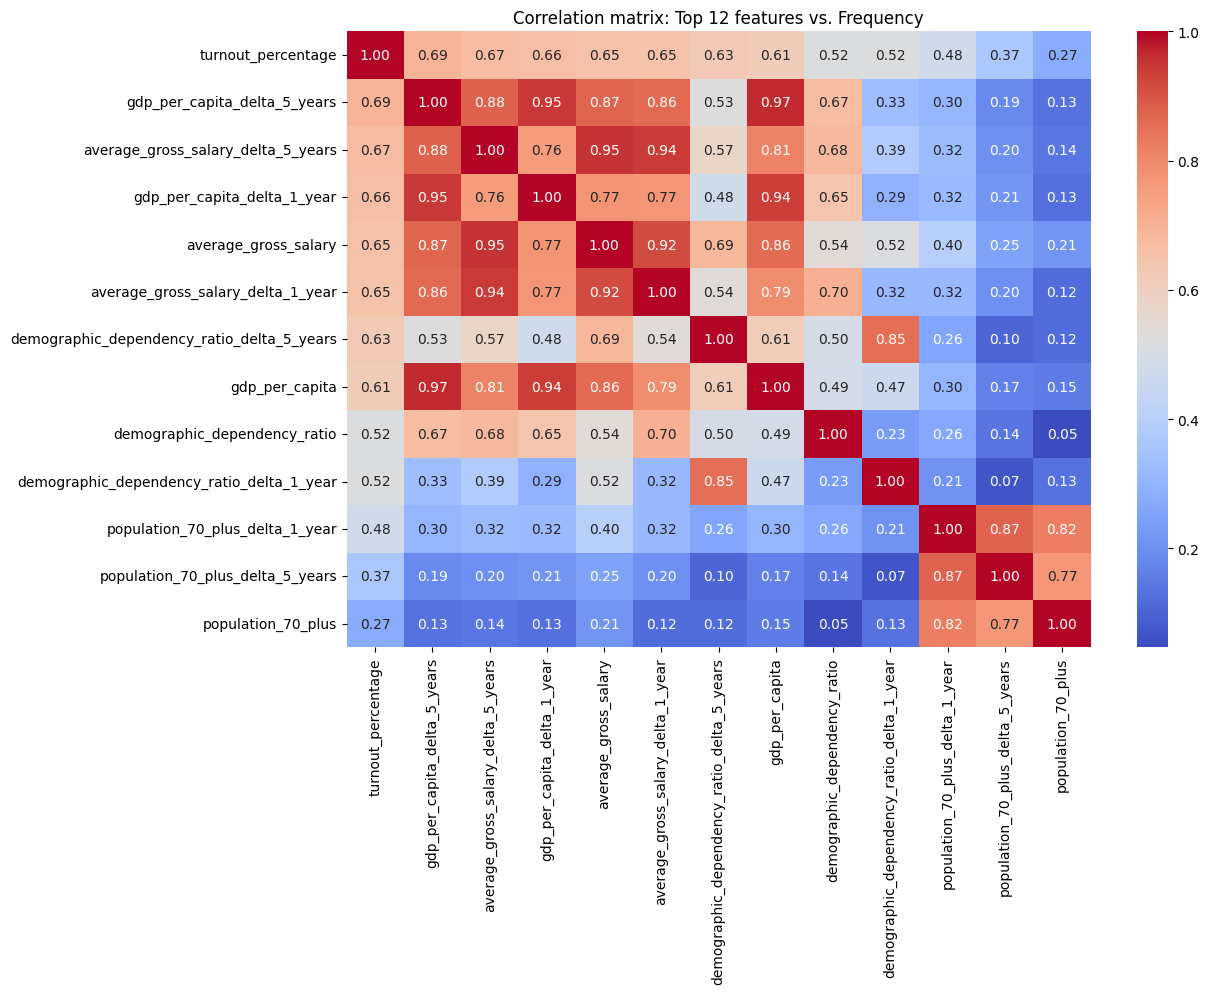

In [10]:
target = "turnout_percentage"
indicator_list = [col for col in model_set_df.columns if col not in ["terc_code", "county", "year", "round", target]]

correlations = model_set_df[[target] + indicator_list].corr()[target].drop(target)
correlations_abs = correlations.abs().sort_values(ascending= False)

plt.figure(figsize= (10, 12))
sns.barplot(x= correlations_abs.values, y= correlations_abs.index, palette= "viridis")
plt.title("Feature ranking: Strength of correlation with attendance (Absolute Correlation)")
plt.xlabel("Correlation value (absolute)")
plt.ylabel("Feature (Indicator / Delta)")
plt.grid(axis= "x", linestyle= "--", alpha= 0.7)
plt.show()

top_12 = correlations_abs.head(12).index.tolist()
plt.figure(figsize= (12, 8))
sns.heatmap(model_set_df[[target] + top_12].corr(), annot= True, cmap= "coolwarm", fmt= ".2f")
plt.title("Correlation matrix: Top 12 features vs. Frequency")
plt.show()

del correlations, correlations_abs
del top_12

### The absolute correlation charts clearly show which features have the greatest impact on attendance.

### The correlation matrix clearly shows which of these 12 features correlate with attendance, and also with each other to a large extent. 

### Due to the fact that, while maintaining all features, the predictive model could contain features that could cause noise due to their mutual correlation, it was decided to limit the features to:
1) ### gdp_per_capita_delta_5_years
2) ### average_gross_salary
3) ### demographic_dependency_ratio
3) ### demographic_dependency_ratio_delta_5_years
3) ### population_70_plus_delta_1_year



In [11]:
columns_to_keep_list = [
    "terc_code", "county", "year", "round", "turnout_percentage", 
    "gdp_per_capita_delta_5_years", "average_gross_salary", 
    "demographic_dependency_ratio", "demographic_dependency_ratio_delta_5_years", 
    "population_70_plus_delta_1_year"
]

model_set_df = model_set_df[columns_to_keep_list]

del columns_to_keep_list

model_set_df.head()

,terc_code,county,year,round,turnout_percentage,gdp_per_capita_delta_5_years,average_gross_salary,demographic_dependency_ratio,demographic_dependency_ratio_delta_5_years,population_70_plus_delta_1_year
0,0201,bolesławiecki,2000,1,58.50,NaN,1860.00,66.0,NaN,NaN
1,0201,bolesławiecki,2005,1,44.16,5084.0,2027.29,56.5,-9.5,252.0
2,0201,bolesławiecki,2005,2,45.09,5084.0,2027.29,56.5,-9.5,252.0
3,0201,bolesławiecki,2010,1,50.33,14142.0,2629.01,52.9,-3.6,55.0
4,0201,bolesławiecki,2010,2,49.09,14142.0,2629.01,52.9,-3.6,55.0


In [12]:
model_set_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   terc_code                                   4180 non-null   str    
 1   county                                      4180 non-null   object 
 2   year                                        4180 non-null   int64  
 3   round                                       4180 non-null   int64  
 4   turnout_percentage                          4180 non-null   float64
 5   gdp_per_capita_delta_5_years                3800 non-null   float64
 6   average_gross_salary                        4180 non-null   float64
 7   demographic_dependency_ratio                4180 non-null   float64
 8   demographic_dependency_ratio_delta_5_years  3800 non-null   float64
 9   population_70_plus_delta_1_year             3800 non-null   float64
dtypes: float64(6), int64(2)

In [13]:
model_set_df.to_parquet("../data/proccesed_data/model_set.parquet")

### Due to the fact that after validating the model on authentic data, i.e. comparing the predictions for 2025 with authentic data, data on indicators until 2030 will be needed, in accordance with the previously established convention, the lag is moved forward one year and then these data are predicted until 2023 using the ARIMA model and the indicator deltas are calculated. 

### The difference is that we limit ourselves only to the column of indicators that were considered key in the visualization process, and then we filter these columns, after calculating deltas, to columns consistent with those in model_set_df.


In [14]:
indicators_to_predict_2030_df.head()

,terc_code,county,year,population_density,population_70_plus,total_population,urbanization_rate,demographic_dependency_ratio,average_gross_salary,unemployment,gdp_per_capita
0,0201,bolesławiecki,1999,67.3,5011.0,88312.0,52.0,66.0,1860.00,8554.0,19537.0
1,0201,bolesławiecki,2000,67.4,5319.0,88194.0,52.0,64.0,1850.00,8886.0,20088.0
2,0201,bolesławiecki,2001,67.5,5627.0,88076.0,52.0,62.0,1840.00,9218.0,20639.0
3,0201,bolesławiecki,2002,67.6,6484.0,88132.0,52.0,60.0,1873.59,8574.0,21744.0
4,0201,bolesławiecki,2003,67.8,6771.0,88308.0,51.0,58.2,1951.43,8803.0,22608.0


In [15]:
columns_to_keep_list = [
    "terc_code", "county", 
    "year", "gdp_per_capita",
    "average_gross_salary", 
    "demographic_dependency_ratio", 
    "population_70_plus"
]

indicators_to_predict_2030_df = indicators_to_predict_2030_df[columns_to_keep_list]
indicators_to_predict_2030_df.head()

,terc_code,county,year,gdp_per_capita,average_gross_salary,demographic_dependency_ratio,population_70_plus
0,0201,bolesławiecki,1999,19537.0,1860.00,66.0,5011.0
1,0201,bolesławiecki,2000,20088.0,1850.00,64.0,5319.0
2,0201,bolesławiecki,2001,20639.0,1840.00,62.0,5627.0
3,0201,bolesławiecki,2002,21744.0,1873.59,60.0,6484.0
4,0201,bolesławiecki,2003,22608.0,1951.43,58.2,6771.0


In [16]:
unique_counties = indicators_to_predict_2030_df["terc_code"].unique()
target_years = [2025, 2026, 2027, 2028, 2029]
target_indicators = columns_to_keep_list[3:]

grouped_data = indicators_to_predict_2030_df.groupby("terc_code")

results_nested = Parallel(n_jobs= -1, prefer= "threads", verbose= 8)(
    delayed(fem.forecast_arima_to_2030)(terc,  group, target_indicators, target_years)
    for terc, group in grouped_data
)

forecast_df = pd.DataFrame([item for sublist in results_nested for item in sublist])

forecast_df = forecast_df.set_index(["terc_code", "year", "county"])

if "terc_code" in indicators_to_predict_2030_df.columns:
    indicators_to_predict_2030_df = indicators_to_predict_2030_df.set_index(["terc_code", "year", "county"])
    
indicators_to_predict_2030_df = indicators_to_predict_2030_df.combine_first(forecast_df)

indicators_to_predict_2030_df = indicators_to_predict_2030_df.reset_index()

del forecast_df, results_nested
del unique_counties
del columns_to_keep_list
del target_years

indicators_to_predict_2030_df[indicators_to_predict_2030_df["year"]==2029]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 380 out of 380 | elapsed: 13.8min finished


,terc_code,year,county,gdp_per_capita,average_gross_salary,demographic_dependency_ratio,population_70_plus
30,0201,2029,bolesławiecki,146902.0,13503.192500,0.000051,13676.499075
61,0202,2029,dzierżoniowski,146902.0,12875.966250,82.800000,17096.608945
92,0203,2029,głogowski,146902.0,13999.598750,80.000000,16274.000000
123,0204,2029,górowski,146902.0,14599.227500,64.465112,4913.874661
154,0205,2029,jaworski,146902.0,13472.570000,0.000057,7808.101074
...,...,...,...,...,...,...,...
11655,3217,2029,wałecki,113342.0,12713.591250,75.227351,7816.794097
11686,3218,2029,łobeski,113342.0,13362.879639,0.000056,5545.058540
11717,3261,2029,Koszalin,113342.0,13789.637500,84.207174,20998.066547
11748,3262,2029,Szczecin,113342.0,15304.753750,77.176031,69451.400000


In [17]:
indicators_to_predict_2030_df = fem.prepare_lagged_features(indicators_to_predict_2030_df, target_indicators)

del target_indicators

indicators_to_predict_2030_df[indicators_to_predict_2030_df["year"]==2030]

,terc_code,year,county,gdp_per_capita,average_gross_salary,demographic_dependency_ratio,population_70_plus,gdp_per_capita_delta_1_year,gdp_per_capita_delta_5_years,average_gross_salary_delta_1_year,average_gross_salary_delta_5_years,demographic_dependency_ratio_delta_1_year,demographic_dependency_ratio_delta_5_years,population_70_plus_delta_1_year,population_70_plus_delta_5_years
30,0201,2030,bolesławiecki,146902.0,13503.192500,0.000051,13676.499075,8346.0,41730.0,1210.537500,5631.812500,-0.001409,-72.199949,288.244643,1613.499075
61,0202,2030,dzierżoniowski,146902.0,12875.966250,82.800000,17096.608945,8346.0,41730.0,1171.055417,5448.706250,1.100000,5.500000,252.627957,1546.608945
92,0203,2030,głogowski,146902.0,13999.598750,80.000000,16274.000000,8346.0,41730.0,1338.102917,6231.168750,0.600000,3.000000,660.000000,3300.000000
123,0204,2030,górowski,146902.0,14599.227500,64.465112,4913.874661,8346.0,41730.0,1563.392500,7256.137500,-2.166610,-7.334888,89.619093,514.874661
154,0205,2030,jaworski,146902.0,13472.570000,0.000057,7808.101074,8346.0,41730.0,1171.960000,5447.400000,-0.001565,-74.799943,148.801889,964.101074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11655,3217,2030,wałecki,113342.0,12713.591250,75.227351,7816.794097,6583.0,32915.0,1103.153750,5144.681250,0.765470,3.827351,163.110756,932.794097
11686,3218,2030,łobeski,113342.0,13362.879639,0.000056,5545.058540,6583.0,32915.0,1247.189395,5987.569639,-0.001535,-74.899944,123.200404,775.058540
11717,3261,2030,Koszalin,113342.0,13789.637500,84.207174,20998.066547,6583.0,32915.0,1276.475833,5917.387500,1.044075,5.207174,482.445864,2516.066547
11748,3262,2030,Szczecin,113342.0,15304.753750,77.176031,69451.400000,6583.0,32915.0,1345.797917,6260.093750,0.896192,4.076031,1271.880000,6359.400000


In [18]:
columns_to_keep_list = [
    "terc_code", "county", "year",	
    "gdp_per_capita_delta_5_years",	"average_gross_salary",	
    "population_70_plus_delta_1_year", "demographic_dependency_ratio", 
    "demographic_dependency_ratio_delta_5_years"
]

indicators_to_predict_2030_df = indicators_to_predict_2030_df[columns_to_keep_list]

del columns_to_keep_list

indicators_to_predict_2030_df.head()


,terc_code,county,year,gdp_per_capita_delta_5_years,average_gross_salary,population_70_plus_delta_1_year,demographic_dependency_ratio,demographic_dependency_ratio_delta_5_years
0,0201,bolesławiecki,2000,NaN,1860.00,NaN,66.0,NaN
1,0201,bolesławiecki,2001,NaN,1850.00,308.0,64.0,NaN
2,0201,bolesławiecki,2002,NaN,1840.00,308.0,62.0,NaN
3,0201,bolesławiecki,2003,NaN,1873.59,857.0,60.0,NaN
4,0201,bolesławiecki,2004,NaN,1951.43,287.0,58.2,NaN


In [19]:
new_rows_df = pd.DataFrame({
    "year": [2030, 2030],
    "round": [1, 2],
    "turnout_percentage": [np.nan, np.nan]
})

unique_counties = election_df[["terc_code", "county"]].drop_duplicates()

rows_to_append = unique_counties.merge(new_rows_df, how= "cross")

election_df = pd.concat([election_df, rows_to_append], ignore_index= True)
election_df = election_df.sort_values(by= ["terc_code", "year", "round"])

del new_rows_df
del unique_counties
del rows_to_append

In [20]:
election_years = [2000, 2005, 2010, 2015, 2020, 2025, 2030]
model_set_2030_df = fem.merge_election_data(election_df, indicators_to_predict_2030_df, election_years)

del election_years

model_set_2030_df.head()

,county,terc_code,turnout_percentage,year,round,gdp_per_capita_delta_5_years,average_gross_salary,population_70_plus_delta_1_year,demographic_dependency_ratio,demographic_dependency_ratio_delta_5_years
0,bolesławiecki,0201,58.50,2000,1,NaN,1860.00,NaN,66.0,NaN
1,bolesławiecki,0201,44.16,2005,1,5084.0,2027.29,252.0,56.5,-9.5
2,bolesławiecki,0201,45.09,2005,2,5084.0,2027.29,252.0,56.5,-9.5
3,bolesławiecki,0201,50.33,2010,1,14142.0,2629.01,55.0,52.9,-3.6
4,bolesławiecki,0201,49.09,2010,2,14142.0,2629.01,55.0,52.9,-3.6


In [21]:
model_set_2030_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4940 entries, 0 to 4939
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   county                                      4940 non-null   object 
 1   terc_code                                   4940 non-null   str    
 2   turnout_percentage                          4180 non-null   float64
 3   year                                        4940 non-null   int64  
 4   round                                       4940 non-null   int64  
 5   gdp_per_capita_delta_5_years                4560 non-null   float64
 6   average_gross_salary                        4940 non-null   float64
 7   population_70_plus_delta_1_year             4560 non-null   float64
 8   demographic_dependency_ratio                4940 non-null   float64
 9   demographic_dependency_ratio_delta_5_years  4560 non-null   float64
dtypes: float64(6), int64(2)

In [22]:
model_set_2030_df.to_parquet("../data/proccesed_data/model_set_2030.parquet")